One-dimensional Poisson model for the geomagnetic dipole moment
=====
***

The dipole field is generated by a series of delta function events. The recurrence time for the source events is governed by a Poisson process. The average recurrence time is fixed but the amplitude of the event is allowed to vary with a uniform distribution $U(a,b)$.  Negative (destructive) events are permitted by adopting a negative lower limit (a<0). The generation of the dipole field depends on the amplitude $A$ and the strength of the dipole field $x$.  In addition, a white noise source is added to the equations for $x$ to allow the field to reverse. We also need an additional white noise source to adjust the duration of transition fields. The imposed noise source has a zero mean and a variance $q_p$.

In [1]:
using Plots
using Distributions
using StatsBase
using DelimitedFiles

The event times are drawn from an expoential distribution with an average recurrence time

mean recurrence time = 0.003002489512350661 Myr


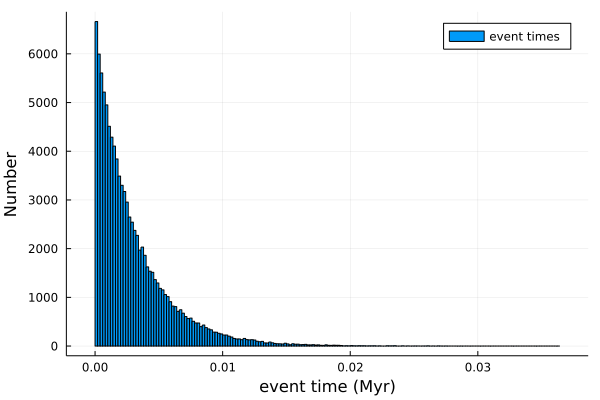

In [2]:
# evaluate event times
myr = 1.0e6;
recurrence = 3000/myr;         # average recurrence time (Myr)
nevents = 100000;
tevent = rand(Exponential(recurrence),nevents);  # Poisson event times
source = zeros(nevents);

# show distribution of event times
println("mean recurrence time = ",mean(tevent)," Myr")
histogram(tevent,label="event times",xlabel="event time (Myr)",ylabel="Number")

Model parameters. We adjust the values of $a$ and $b$ in the uniform distribution $U(a,b)$ to produce desired mean and variance of x(t))

In [3]:
# amplitude fluctuations
A = 0.225

amp_p = rand(Uniform(-0.4*A,5.9*A),nevents) # draw amplitude fluctuations from U(a,b)

# include random (white) noise
np = rand(Normal(),2*nevents);
qp = 180;       #  poloidal noise variance

# quenching magnitude
x0 = 4.7;         # defines onset of quenching; we chose a value slightly below the average <x>

4.7

We integrate the governing equations for the dipole field in two steps. The event interval is divided in half. Over the first half we have dipole decay and a white noise source. Over the second half we have dipole decay, white noise and a Poisson source event. The goal is to provide intermediate solutions for $x(t)$ between the source events. This helps when we interpolate the solution onto a uniform time spacing.

In [4]:
# allocate memory for solution
x = zeros(2*nevents);
t = zeros(2*nevents);

# set decay rate for dipole (here gamma = 1/tau_d, where tau_d is dipole decay time)
gamma = 0.1 * 1000;

# initial condition
t[1] = 0.0;
x[1] = 5.0;
j = 2;

# integrate over the number of source events
for i = j : nevents
    
    # relax half a time step 
    dt = tevent[i]/2.0;
    t[j] = t[j-1] + dt;
    gp = exp(-x[j-1]^2/2.2^2);
    x[j] = x[j-1] * exp(-gamma * dt) + np[j]*sqrt(gp*qp*dt);;
    
    # relax rest of time step
    j += 1;
    t[j] = t[j-1] + dt;
    x[j] = x[j-1] * exp(-gamma * dt)
    
    # evaluate quenching
    fp = 1.0/ (1.0 + (x[j]/x0)^2);
    
    # add event and random noise
     gp = exp(-x[j]^2/2.2^2)
    x[j] += amp_p[i] * x[j] * fp + np[j]*sqrt(gp*qp*dt); 
    source[i] = amp_p[i] * x[j] * fp + np[j]*sqrt(gp*qp*dt);
    j+= 1;
    
end

# fill last entry
t[end] = t[end-1] + tevent[end]/2.0
x[end] = x[end-1]
println("mean x = ",mean(abs.(x))," std x = ",std(abs.(x))," skewness = ",skewness(abs.(x)))

mean x = 4.9253781027381836 std x = 2.5549777685706707 skewness = 0.26160984209747523


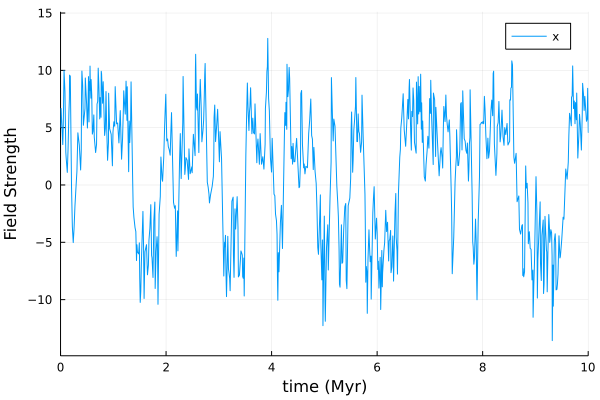

In [5]:
# print time series 
idecimate = 10;
plot(t[1:idecimate:end],(x[1:idecimate:end]),
    label="x",xlabel="time (Myr)",
    ylabel="Field Strength",
    xlim=(0,10))

In [6]:
savefig("TimeSeries_Poisson3000.pdf")

In [7]:
# save to file
save_file = true
      
if save_file
    open("dipole_3000.txt","w")  do io
        writedlm(io,[t x])
    end
end

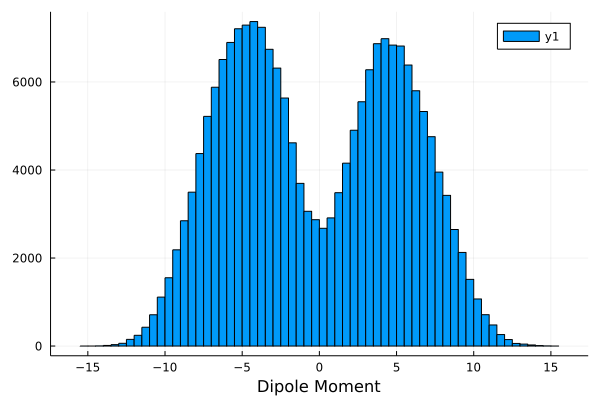

In [8]:
h = fit(Histogram,x,nbins=100)
plot(h,xlabel="Dipole Moment")

Fold the dipole moment with negative values to postive values

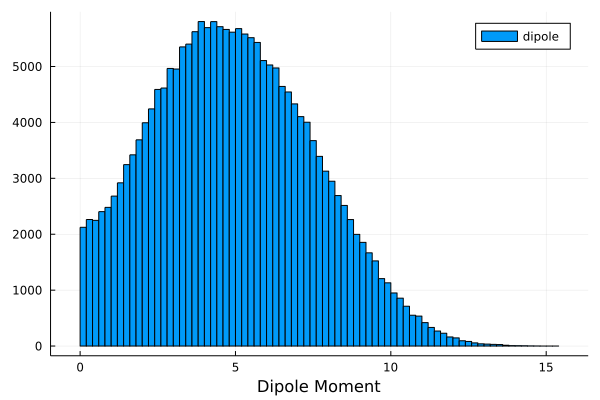

In [9]:
p1=histogram(abs.(x),xlabel="Dipole Moment",label="dipole")
plot(p1)

Evaluates the mean amplitudes $<A>$ and $<A^2>$, which appear in the definition of the drift $D_1$ and diffusion  $D_2$ terms.

In [10]:
function amplitudes(Ax,rate)
#
# evaluates the mean amplitudes <A>, <A2>, <A3.
# for poloidal and toroidal events
#
# input
# Ax, Ay - nominal amplitude of x and y events
# rate -  dimensionless rate of Poisson process

# output
# Ap, At  - mean amplitudes e.g. Ap[1,2,3]

# maximum and minimum amplitudes
Apmin = -0.4 * Ax;    # need to match the amplitude limits in U(a,b) from above
Apmax = 5.9 * Ax;



Ap = zeros(3);

Ap[1] = rate*(Apmin+Apmax)/2.0;
Ap[2] = rate*(Apmax^2 + Apmin^2 + Apmax*Apmin)/3.0;
Ap[3] = rate*(Apmax + Apmin)*(Apmax^2+Apmin^2)/4.0;



return Ap

end


amplitudes (generic function with 1 method)

507.437319046198


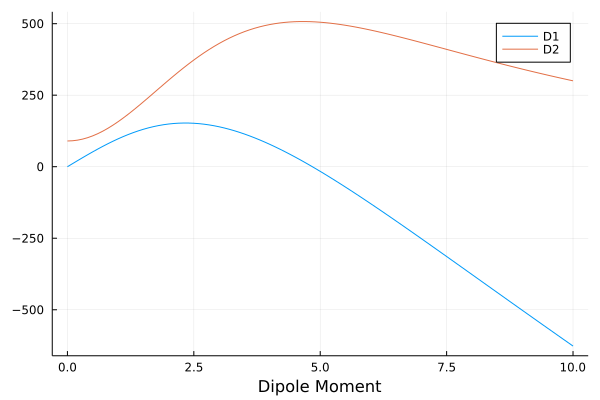

In [11]:
# compute drift and diffusion terms
rate = 1/recurrence
xbar = mean(abs.(x));
Ap = amplitudes(A,rate)


xplot = (0 : 0.1 : 10.0);
D1 = zeros(length(xplot))
D2 = zeros(length(xplot))
v = zeros(length(xplot))

for i = 1 : length(xplot)
    f = 1.0 / (1.0 + (xplot[i]/x0)^2);
    g = exp(-xplot[i]^2/2.2^2)
    D1[i] = -gamma*xplot[i] + Ap[1]*xplot[i]*f;
    D2[i] = 0.5*Ap[2]*(xplot[i]^2)*(f^2) + 0.5 * qp*g;
   # D3[i] = (1/6.0) * Ap[3]*(xplot[i]^2)*(f^3);
end

println(maximum(D2))
plot(xplot,D1,xlabel="Dipole Moment", label = "D1")
plot!(xplot,D2,label = "D2")


The histogram shows a noise source with $<dS> =0$, but it deviates significantly from $N(0,dt)$.

In [12]:
savefig("Drift&Diffusion.pdf")